In [1]:
from google.colab import userdata
groq_api = userdata.get('groq_api_key')
lc_api = userdata.get('lc_api_key')

In [2]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = lc_api
os.environ["LANGCHAIN_PROJECT"] = "colab-test"
os.environ["GROQ_API_KEY"] = groq_api

In [3]:
!pip install -Uq "unstructured[all-docs]" pillow lxml
!pip install -Uq chromadb tiktoken
!pip install -Uq langchain langchain-community langchain-groq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 29.5 MB/s eta 0:00:00
   ━━━━━━

In [4]:
# Install Poppler for PDF processing
!apt-get install -y poppler-utils



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 1 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 0s (933 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 122127 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


# Extract the data

Extract the elemets of the PDF that we will be able to use in the retrieval process.

### Partition PDF text, images or tables

In [5]:
from unstructured.partition.pdf import partition_pdf

output_path = "/content/drive/MyDrive/storypdf/"
file_path = output_path + 'short-story.pdf'

chunks = partition_pdf(
    filename = file_path,
    #infer_table_structure=True,               # extract tables
    #strategy='hi_res',                        # mandatory to infer tables

    extract_image_block_types=["Image"],      # Add 'Table' to list to extract image of tables
    image_output_dir_path="/content/drive/MyDrive/storypdf/",        # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,      # if true, will extract base64 for API usage

    chunking_strategy="by_title",             # or'basic'
    max_characters=10000,                     # defaults to 500
    combine_text_under_n_chars=2000,          # defaults to 0
    new_after_n_chars=6000,

)

yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

In [6]:
# we got 1 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [7]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[1].metadata.orig_elements

In [8]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[1].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': 'c61fc1a7-265d-4144-b244-5893ccdf67dc',
 'text': '10 ',
 'metadata': {'coordinates': {'points': ((np.float64(-2.8335863888888886),
     np.float64(1028.475397222222)),
    (np.float64(-2.8335863888888886), np.float64(1656.9395544444442)),
    (np.float64(1181.1022994444445), np.float64(1656.9395544444442)),
    (np.float64(1181.1022994444445), np.float64(1028.475397222222))),
   'system': 'PixelSpace',
   'layout_width': 2363,
   'layout_height': 1654},
  'last_modified': '2025-07-26T12:01:36',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 6,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAJ1BKADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk

### Separate extracted elements into text, images and tables

In [9]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
      tables.append(chunk)

    if "CompositeElement" in str(type(chunk)):
      texts.append(chunk)

In [10]:
# Get the images from the CompositeElement objects

def get_images_base64(chunks):
  images_b64 = []
  for chunk in chunks:
    if "CompositeElement" in str(type(chunk)):
      chunk_els = chunk.metadata.orig_elements
      for el in chunk_els:
        if "Image" in str(type(el)):
          images_b64.append(el.metadata.image_base64)
  return images_b64

images = get_images_base64(chunks)

### Check what the images look like

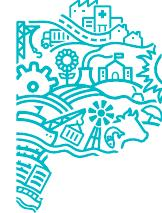

In [11]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
  # Decode the base64 string to binary
  image_data = base64.b64decode(base64_code)
  # Display the image
  display(Image(data=image_data))

display_base64_image(images[0])

# Summarize the data

### text and table summaries

In [12]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [13]:
# prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""

prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary Chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [14]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [15]:
table_summaries

[]

### Image summaries

In [ ]:
prompt_template = """Describe the image in detail. For context,
              the image part of the story for kids."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
chain = prompt | model | StrOutputParser()


image_summaries = chain.batch(images)

In [34]:

# 1. Create a prompt template with a placeholder for the image
prompt = ChatPromptTemplate.from_messages([
    (
        "user",
        [
            {"type": "text", "text": """Describe the image in detail. For context,
              the image part of the story for kids."""},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
])

# 2. Your list of base64 images (strip whitespace if needed / img.strip())
# Example: images = ["/9j/4AAQSkZJRgABAQ...", "iVBORw0KGgoAAAANSUhEUg..."]
image_dicts = [{"image": img} for img in images]

# 3. Setup the chain
model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
chain = prompt | model | StrOutputParser()

# 4. Run in batch
image_summaries = chain.batch(image_dicts)

# 5. Print results
#for i, summary in enumerate(image_summaries):
#    print(f"\n📄 Image {i+1} Summary:\n{summary}")


In [33]:
print(image_summaries[1])


The image presents a serene and idyllic scene of a house nestled among trees, captured within a circular frame. The house, situated in the center of the image, features a white base with brown trim and a distinctive red roof. A chimney rises from the roof's peak on the left side.

In the foreground, several large trees with light-brown trunks dominate the landscape, their branches stretching across the top of the image. The trees are adorned with vibrant green leaves, while the surrounding grassy area is dotted with blue flowers or bushes. The overall atmosphere of the image exudes peace and tranquility, evoking a sense of a secluded retreat or a picturesque village setting. The circular shape of the image adds to its charm, creating a sense of intimacy and coziness.


# Load data and summaries to vectorestore

### Create the vectorstore

In [43]:
%pip install --upgrade --quiet  sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 9.1 MB/s eta 0:00:00


In [44]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

/tmp/ipython-input-44-719859098.py:6: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  hf = HuggingFaceBgeEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
%pip install --upgrade --quiet  langchain-google-genai

In [60]:

import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
#from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever


# The vectorstore to use to index the child chunks
#embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07")
embeddings = hf
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embeddings)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriver ( empty to start )
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

### Load the sumaries and link them to the original data

In [71]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate( image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

# Add tables
#table_ids = [str(uuid.uuid4()) for _ in tables]
#summary_tables = [
#    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
#]
#retriever.vectorstore.add_documents(summary_tables)
#retriever.docstore.mset(list(zip(table_ids, tables)))

### Check retrieval

In [72]:
# Retrieve
docs = retriever.invoke(
    "Who is the little princess?"
)

In [73]:
for doc in docs:
  print(str(doc) + "\n\n" + "-" * 80)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCALRA4gDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDrPi1/x/aZ/wBc3/mK84NejfFv/j+0z/rk/wDMV5yaZxVfjY003NONMPWggWiigUgHClNIKdQAwDBp2aQimnigCQUh5oB4pM0xCHikzS5zxTWBU8DOaRVxc0maTBprZFILis2KjaU9qbIdy46Gmr93FUI6fwk2dUjHB6nJ69K9

In [ ]:
from langchain_core.documents import Document
def extract_page_numbers_from_chunk(chunk):
  elements = chunk.metadata.orig_elements

  page_numbers = set()
  for element in elements:
    page_numbers.add(element.metadata.page_number)

  return page_numbers

extract_page_numbers_from_chunk(chunks[0])

def display_chunk_pages(chunk):


# RAG pipeline

In [78]:

from base64 import b64decode
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.runnables import RunnablePassthrough, RunnableLambda



In [87]:



def parse_docs(docs):
  """split base64-encoded images and texts"""
  b64 = []
  text = []
  for doc in docs:
    try:
      b64decode(doc)
      b64.append(doc)
    except Exception as e:
      text.append(doc)
  return {"images": b64, "texts": text}

def build_prompt(kwargs):
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0 :
      for text_element in docs_by_type["texts"]:
        context_text += text_element.text

    #construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
      for image in docs_by_type["images"]:
        prompt_content.append(
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
        )

      return ChatPromptTemplate.from_messages(
      [
        HumanMessage(content = prompt_content)
      ]
  )

chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
        | StrOutputParser()
    )
)



In [85]:
response = chain.invoke(
    " what is the second story about?"
)
print(response)

The second story appears to be about Snow White and the Seven Dwarfs. The image shows a girl waking up to find seven dwarfs looking at her, which is a key scene from the classic fairy tale. 

Therefore, the second story is about a girl named Snow White who takes refuge with a group of friendly dwarfs.


response: There is no previous story to summarise; this is the beginning of the conversation.


context:


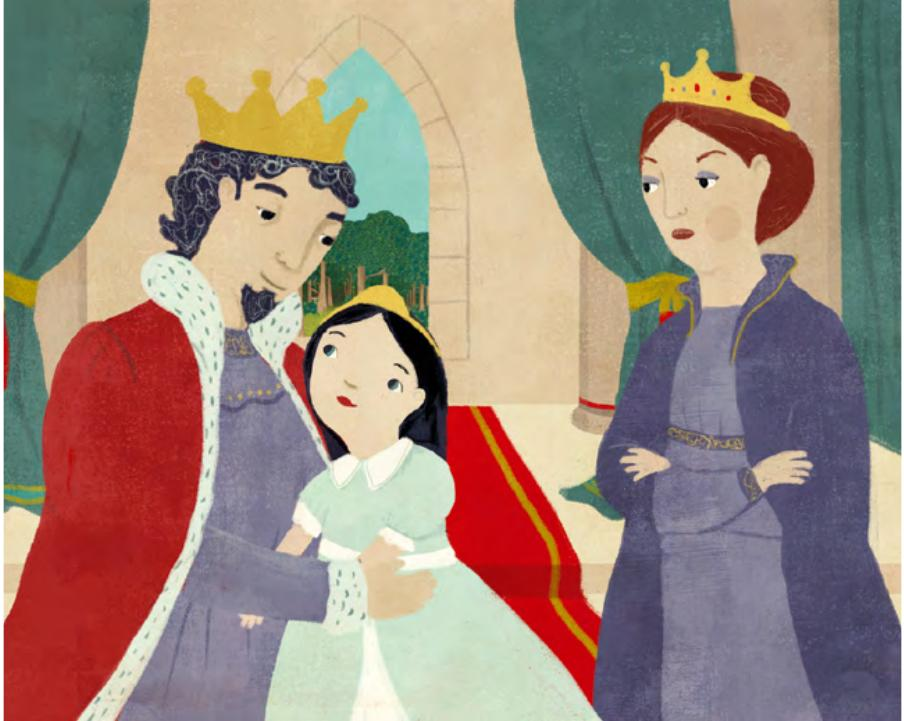

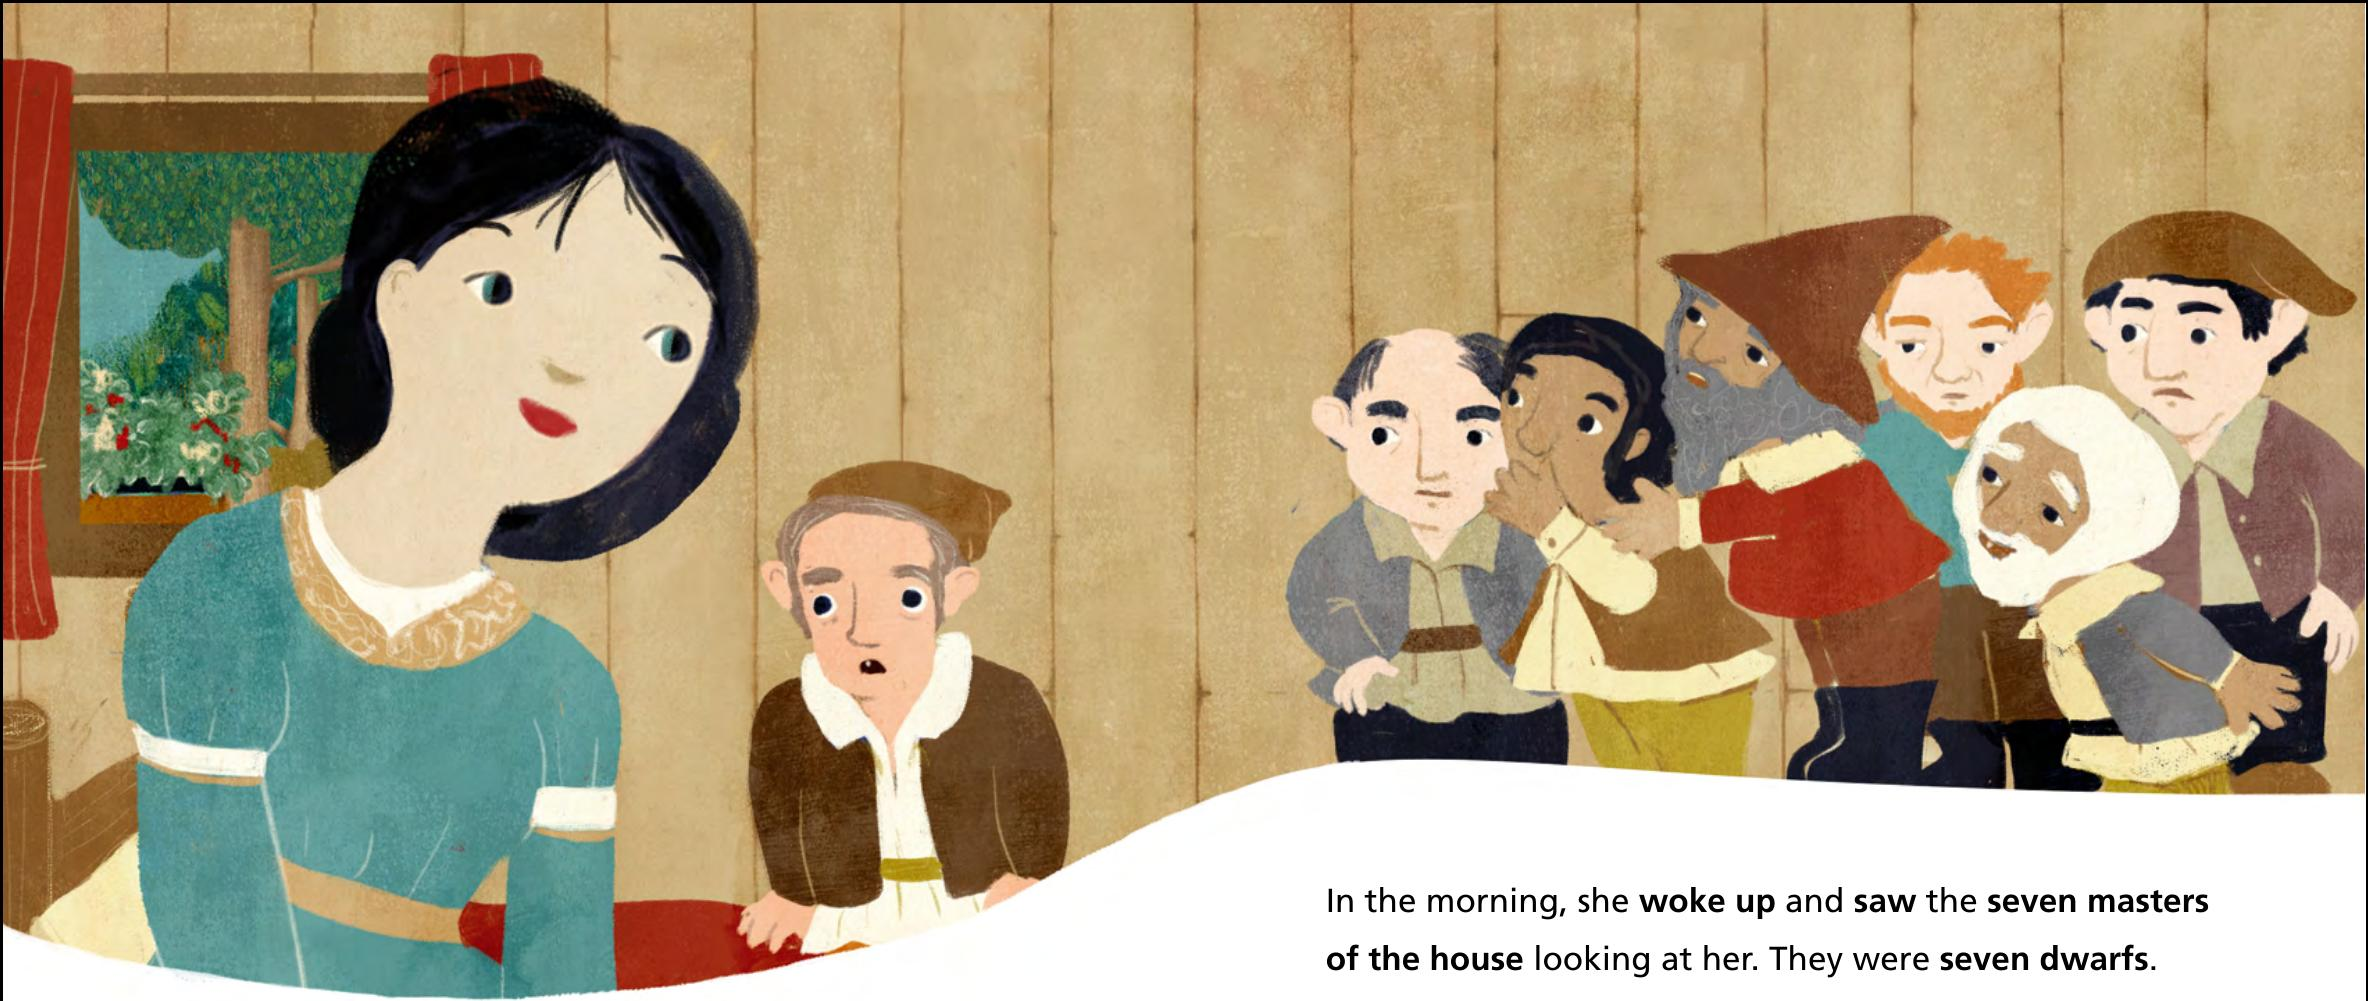

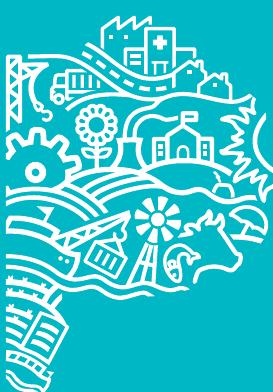

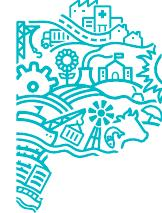

In [92]:
response = chain_with_sources.invoke(
    "summarise the last story and show the images"
)
print("response:", response['response'])

print("\n\ncontext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)